In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv("../datasets/housing/housing.csv")

## 纯随机抽样

我们采用的都是纯随机的取样方法。当你的数据集很大时（尤其是和属性数相比） ，这通常可行；但如果数据集不大，就会有采样偏差的风险.

In [3]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [4]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


## 分层抽样

假设专家告诉你，收入中位数是预测房价中位数非常重要的属性。你可能想要保证测试集可以代表整体数据集中的多种收入分类。
需要进行分层抽样

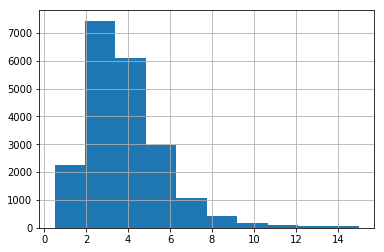

In [5]:
housing['median_income'].hist()

大多数的收入中位数的值聚集在 2-5（万美元） ，但是一些收入中位数会超过 6。数据集中的每个分层都要有足够的实例位于你的数据中，这点很重要。否则，对分层重要性的评估就会有偏差。这意味着，你不能有过多的分层，且每个分层都要足够大。

In [6]:
#对收入中位数进行分类，因为收入中位数是连续数据
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5) #ceil向上取整
#将所有大于 5的分类归入到分类 5
housing['income_cat'].where(housing['income_cat'] < 5,5.0,inplace=True)

In [7]:
housing['income_cat'].head()

0    5.0
1    5.0
2    5.0
3    4.0
4    3.0
Name: income_cat, dtype: float64

In [8]:
housing['income_cat'].max()

5.0

In [9]:
#分层抽样
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index,test_index in split.split(housing,housing['income_cat']):
    start_train_set = housing.loc[train_index]
    start_test_set = housing.loc[test_index]

In [10]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [11]:
#删除 income_cat 属性，使数据回到初始状态
for set in (start_train_set, start_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# 探索数据

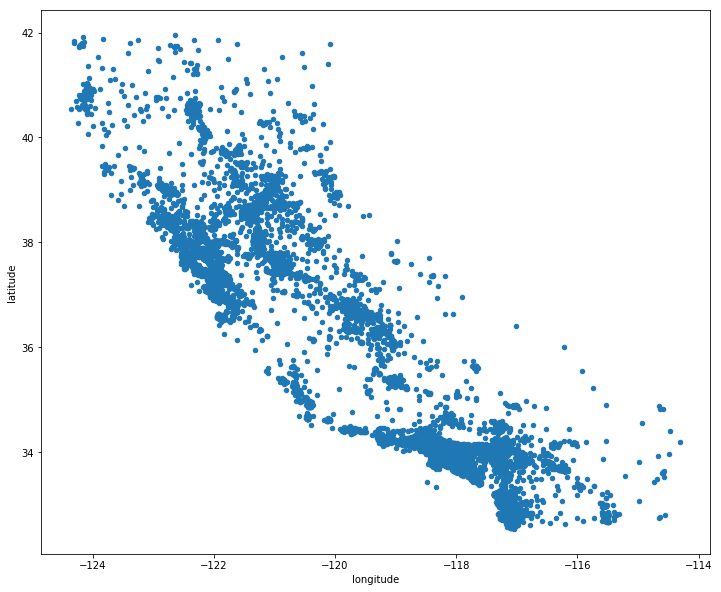

In [12]:
housing = start_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude",figsize=(12,10))

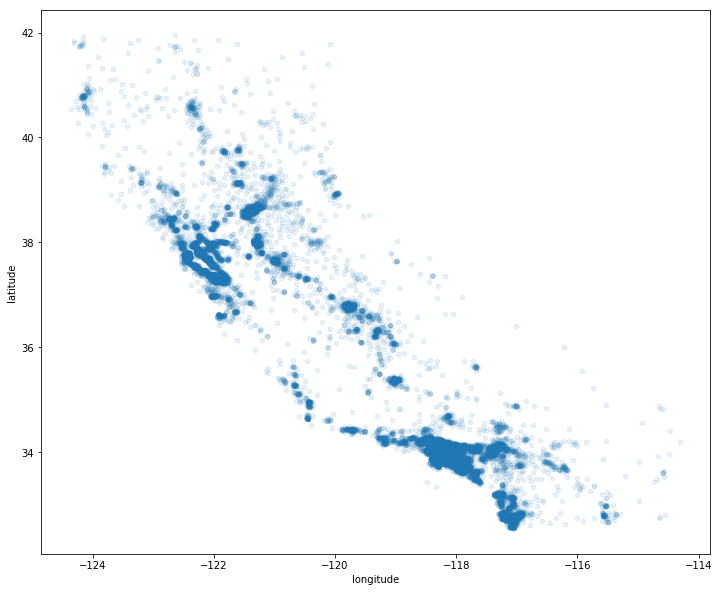

In [13]:
#调整alpha值 观察数据密度
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,figsize=(12,10))

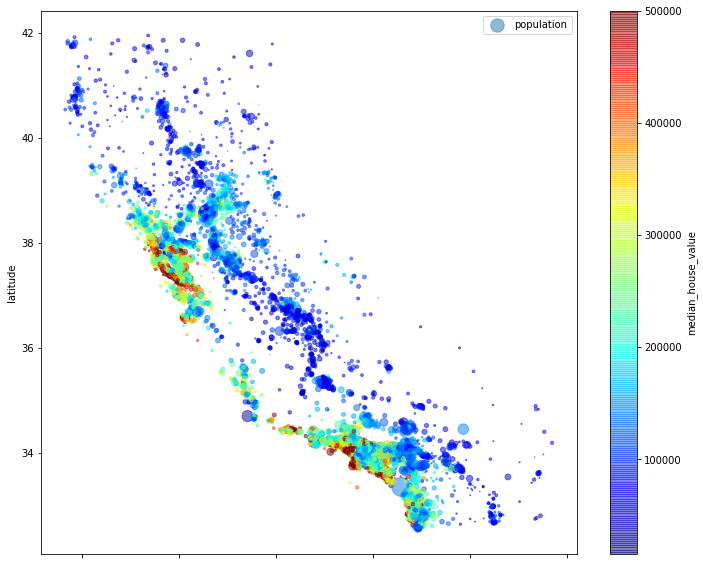

In [14]:
#每个圈的半径表示街区的人口（选项 s ） ，
#颜色代表价格（选项 c ） 。我们用预先定义的名为 jet 的颜色图（选项 cmap ） ，
#它的范围是从蓝色（低价）到红色（高价） ：
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,figsize=(12,10))
plt.legend()

这张图说明房价和位置（比如，靠海） 和人口密度联系密切，这点你可能早就知道

# 查找关联

通过计算属性间的标准相关系数，查看各属性间的关系

In [15]:
corr_matrix = housing.corr()
#各属性和房价中位数的关联度
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

相关系数的范围是 -1 到 1。当接近 1 时，意味强正相关；例如，当收入中位数增加时，房价
中位数也会增加。当相关系数接近 -1 时，意味强负相关；你可以看到，纬度和房价中位数有
轻微的负相关性（即，越往北，房价越可能降低） 。最后，相关系数接近 0，意味没有线性相关性。同时相关不等于因果

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F34B393048>,
      dtype=object)

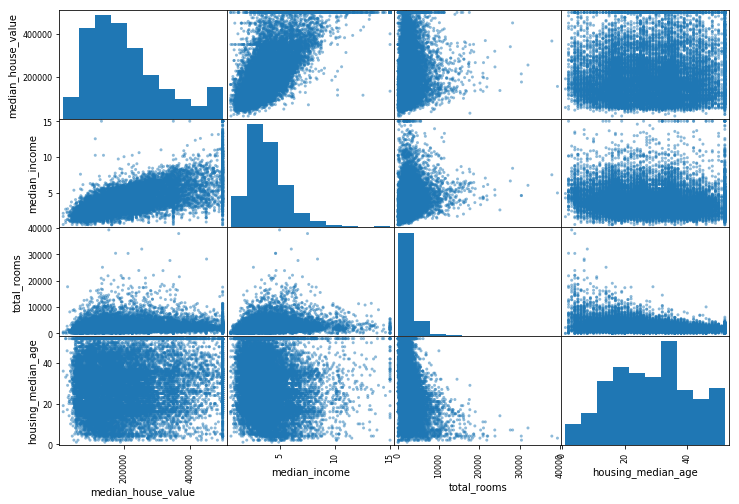

In [16]:
#图示属性间相关系数
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

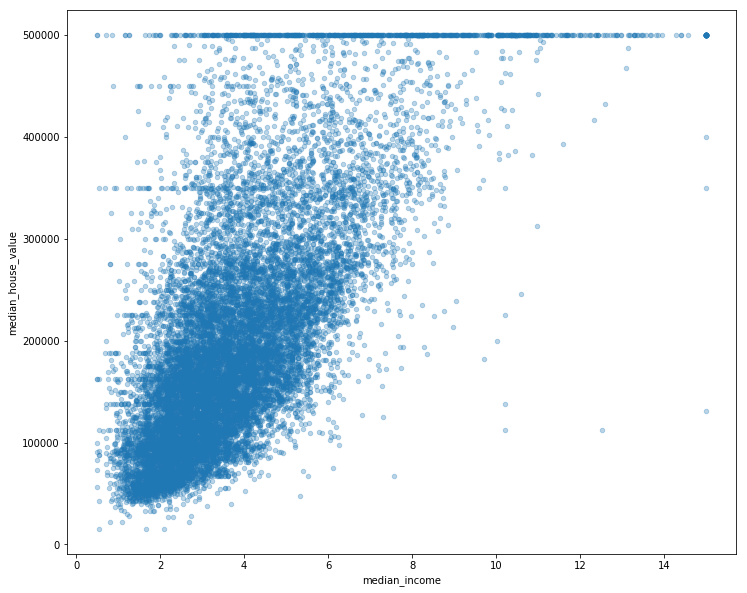

In [17]:
#通过上面图像的观察，房价中文数和收入中位数有正相关的趋势
#最有希望用来预测房价中位数的属性是收入中位数，因此将这张图放大
housing.plot(kind="scatter", x="median_income",y="median_house_value",alpha=0.3,figsize=(12,10))

这张图说明了几点。首先，相关性非常高；可以清晰地看到向上的趋势，并且数据点不是非常分散。第二，我们之前看到的最高价，清晰地呈现为一条位于 500000 美元的水平线。这张图也呈现了一些不是那么明显的直线：一条位于 450000 美元的直线，一条位于 350000 美元的直线，一条在 280000 美元的线，和一些更靠下的线。你可能希望去除对应的街区，以防止算法重复这些巧合

# 属性组合实验

给算法准备数据之前，你需要做的最后一件事是尝试多种属性组合。例如，如果你不知道某个街区有多少户，该街区的总房间数就没什么用。你真正需要的是每户有几个房间。相似的，总卧室数也不重要：你可能需要将其与房间数进行比较。每户的人口数也是一个有趣的属性组合

In [18]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [19]:
corr_matrix =housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

看起来不错！与总房间数或卧室数相比，新的 bedrooms_per_room 属性与房价中位数的关联更强。显然，卧室数/总房间数的比例越低，房价就越高。每户的房间数也比街区的总房间数的更有信息，很明显，房屋越大，房价就越高

对于一些没有呈现正态分布的属性，可以通过一些变换进行处理（如log等）

# 为机器学习算法准备数据

建立一些函数，方便以后重复使用

## 数据清洗

In [20]:
#将预测量和标签分开，因为我们不想对预测量和目标值应用相同的转换
housing = start_train_set.drop('median_house_value',axis=1)
housing_labels =start_train_set['median_house_value'].copy()

In [21]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [22]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

前面，我们应该注意到了属性 total_bedrooms 有一些缺失值。有三个解决选项：
- 去掉对应的街区；
- 去掉整个属性；
- 进行赋值（0、平均值、中位数等等）

```
housing.dropna(subset=["total_bedrooms"]) # 选项1
housing.drop("total_bedrooms", axis=1) # 选项2
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median) # 选项3
```

In [23]:
#使用中位数进行赋值
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [24]:
#因为只有数值属性才能算出中位数，我们需要创建一份不包括文本属性 ocean_proximity 的数据副本
housing_num = housing.drop('ocean_proximity',axis=1)

In [25]:
#对训练数据拟合
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [26]:
#计算出的中位数
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [27]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [28]:
#可以看到total_bedrooms有部分缺失值
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


In [29]:
#对训练集进行填充
X = imputer.transform(housing_num)

In [30]:
#结果是一个包含转换后特征的普通的 Numpy 数组,可以转化为dataframe
housing_tr = pd.DataFrame(X,columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [31]:
#通过info可以观察到数据数目相同，没有缺省值
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


## 处理文本和类别属性

In [32]:
#把这些文本标签转换为数字
housing_cat = housing['ocean_proximity']
housing_cat_encoded,housing_categories = housing_cat.factorize()
housing_cat_encoded

array([0, 0, 1, ..., 2, 0, 3], dtype=int64)

In [33]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

这种做法的问题是，ML 算法会认为两个临近的值比两个疏远的值要更相似。显然这样不对

要解决这个问题，可以使用独热编码（One-Hot Encoding）

In [34]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) #因为用于2D数组，所以需要变形
housing_cat_1hot#是一个稀疏矩阵

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [35]:
#转为密集的numpy数组
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

CategoricalEncoder在sklearn0.21被移除了，0.20版本有

对于标签，可使用类 LabelBinarizer ，我们可以用一步执行这两个转换（从文本分类到整数分类，再从整数分类到独热向量） 
默认返回密集数组

## 特征缩放

有两种常见的方法可以让所有的属性有相同的量度：线性函数归一化（Min-Max scaling） 和标准化（standardization）

- 线性函数归一化（许多人称其为归一化（normalization） ） 很简单：值被转变、重新缩放，
直到范围变成 0 到 1
- 标准化就很不同：首先减去平均值（所以标准化值的平均值总是 0） ，然后除以方差，使得到的分布具有单位方差。与归一化不同，标准化不会限定值到某个特定的范围，这对某些算法可能构成问题（比如，神经网络常需要输入值得范围是 0 到 1）。但是，标准化受到异常值的影响很小

## 流水线转换

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
#后两列就是组合的属性
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, str):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if self.handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using specified encoding scheme.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, str):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

    def inverse_transform(self, X):
        """Convert back the data to the original representation.
        In case unknown categories are encountered (all zero's in the
        one-hot encoding), ``None`` is used to represent this category.
        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.
        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.
        """
        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if self.encoding == 'ordinal' and X.shape[1] != n_features:
            raise ValueError(msg.format(n_features, X.shape[1]))
        elif (self.encoding.startswith('onehot')
                and X.shape[1] != n_transformed_features):
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        if self.encoding == 'ordinal':
            for i in range(n_features):
                labels = X[:, i].astype('int64')
                X_tr[:, i] = self.categories_[i][labels]

        else:  # encoding == 'onehot' / 'onehot-dense'
            j = 0
            found_unknown = {}

            for i in range(n_features):
                n_categories = len(self.categories_[i])
                sub = X[:, j:j + n_categories]

                # for sparse X argmax returns 2D matrix, ensure 1D array
                labels = np.asarray(_argmax(sub, axis=1)).flatten()
                X_tr[:, i] = self.categories_[i][labels]

                if self.handle_unknown == 'ignore':
                    # ignored unknown categories: we have a row of all zero's
                    unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                    if unknown.any():
                        found_unknown[i] = unknown

                j += n_categories

            # if ignored are found: potentially need to upcast result to
            # insert None values
            if found_unknown:
                if X_tr.dtype != object:
                    X_tr = X_tr.astype(object)

                for idx, mask in found_unknown.items():
                    X_tr[mask, idx] = None

        return X_tr

In [40]:
# from sklearn.preprocessing import LabelBinarizer

# num_attribs = list(housing_num)
# cat_attribs = ["ocean_proximity"]

# num_pipeline = Pipeline([
#     ('selector', DataFrameSelector(num_attribs)),
#     ('imputer',SimpleImputer(strategy='median')),
#     ('attribs_adder',CombinedAttributesAdder()),
#     ('std_scaler',StandardScaler()),
# ])

# cat_pipeline = Pipeline([
#     ('selector', DataFrameSelector(cat_attribs)),
#     ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
# ])

# full_pipeline = Pipeline([
#     ('num_pipeline',num_pipeline),
#     ('cat_pipeline',cat_pipeline),
# ])
# housing_prepared = full_pipeline.fit_transform(housing)
# housing_prepared

In [41]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [42]:
housing_num_tr.shape

(16512, 11)

In [43]:
#函数有问题，暂时先用2个数据合成
housing_prepared = np.hstack((housing_num_tr,housing_cat_1hot.toarray()))
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [55]:
#对比书上好像少了个特征，具体没发现是哪个
#更新，通过后面的计算 好像就是16个特征
housing_prepared.shape

(16512, 16)

In [44]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

大多数街区的 median_housing_values 位于 120000到 265000 美元之间预测误差 68628 美元不能让人满意,这是一个模型欠拟合训练数据的例子。  
使用一个更强大的模型

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [47]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse #明显过拟合

0.0

## 交叉验证

In [48]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,
                        scoring='neg_mean_squared_error',cv=10)
tree_rsme_scores = np.sqrt(-scores)

>Scikit-Learn 交叉验证功能期望的是效用函数（越大越好） 而不是损失函数（越低
越好） ，因此得分函数实际上与 MSE 相反（即负值） ，这就是为什么前面的代码在计算
平方根之前先计算 -scores 

In [49]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [50]:
display_scores(tree_rsme_scores)

Scores: [69297.00478777 67854.68672789 71429.12783403 70331.31783897
 70812.00746011 75988.98268065 70785.56193773 72364.87947891
 77659.16188859 72121.60762924]
Mean: 71864.433826389
Standard deviation: 2799.796888895293


In [51]:
lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels,
                           scoring='neg_mean_squared_error',cv=10)
lin_rmse_score = np.sqrt(-lin_scores)
display_scores(lin_rmse_score)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


决策树模型过拟合很严重，它的性能比线性回归模型还差

In [52]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)

D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [53]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse 

22307.41240039842

In [54]:
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,
                           scoring='neg_mean_squared_error',cv=10)
forest_rmse_score = np.sqrt(-forest_scores)
display_scores(forest_rmse_score)

Scores: [52118.22577125 50657.54767588 53425.47816624 54838.08793936
 51797.18013924 54945.74460132 51708.694407   50265.71617975
 56037.09064909 52716.34838388]
Mean: 52851.011391300766
Standard deviation: 1824.3652384902643


可以看到随机森林的效果还要好些。但是，训练集的评分仍然比验证集的评分低很多，存在过拟合。  
解决过拟合可以通过简化模型，给模型加限制（即，正则化） ，或用更多的训练数据

## 模型微调

### 网格搜索

In [56]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg,param_grid,cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [57]:
#因为 30 是 n_estimators 的最大值，你也应该估计更高的值，因为评估的分数可能会随 n_estimators 的增大而持续提升
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [58]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [59]:
cvres = grid_search.cv_results_
for mean_score,params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

65486.44005130747 {'max_features': 2, 'n_estimators': 3}
55296.4643575446 {'max_features': 2, 'n_estimators': 10}
53275.34762631252 {'max_features': 2, 'n_estimators': 30}
61283.3976219532 {'max_features': 4, 'n_estimators': 3}
52852.88796438026 {'max_features': 4, 'n_estimators': 10}
50553.05327643044 {'max_features': 4, 'n_estimators': 30}
58362.8083629385 {'max_features': 6, 'n_estimators': 3}
52214.56445538374 {'max_features': 6, 'n_estimators': 10}
50036.738628770094 {'max_features': 6, 'n_estimators': 30}
59063.841635984165 {'max_features': 8, 'n_estimators': 3}
51905.18399728042 {'max_features': 8, 'n_estimators': 10}
50002.03442618869 {'max_features': 8, 'n_estimators': 30}
62775.941923847626 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54095.27944486858 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60400.58670911812 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52266.11641394163 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

这里得到的最佳组合的RMSE 的值是 50002，这比之前使用默认的超参数的值（52851） 要稍微好一些，说明成功微调了模型！

>提示：不要忘记，你可以像超参数一样处理数据准备的步骤。例如，网格搜索可以自动
判断是否添加一个你不确定的特征（比如，使用转换器 CombinedAttributesAdder 的超参
数 add_bedrooms_per_room ） 。它还能用相似的方法来自动找到处理异常值、缺失特征、
特征选择等任务的最佳方法。

网格搜索适合探索组合较少的，当但是当超参数的搜索空间很大时，最好使用随机搜索（ RandomizedSearchCV ）  
随机搜索2个优点：
- 如果你让随机搜索运行，比如 1000 次，它会探索每个超参数的 1000 个不同的值（而不是像网格搜索那样，只搜索每个超参数的几个值） 。
- 你可以方便地通过设定搜索次数，控制超参数搜索的计算量。

## 分析最佳模型和它们的误差

In [60]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.80959168e-02, 6.49279573e-02, 4.20619495e-02, 1.50569894e-02,
       1.41849941e-02, 1.49700365e-02, 1.43135582e-02, 3.79212288e-01,
       4.41612431e-02, 1.15578628e-01, 6.18371086e-02, 7.74051950e-03,
       3.40316542e-03, 1.51159324e-01, 3.18437742e-03, 1.11944396e-04])

In [62]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(housing_categories)
attributes = list(housing_num) + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances,attributes),reverse=True)

[(0.3792122877614709, 'median_income'),
 (0.15115932436007462, 'INLAND'),
 (0.11557862763880258, 'pop_per_hhold'),
 (0.06809591684355208, 'longitude'),
 (0.06492795730769196, 'latitude'),
 (0.06183710859072488, 'bedrooms_per_room'),
 (0.04416124307106211, 'rooms_per_hhold'),
 (0.04206194949970908, 'housing_median_age'),
 (0.015056989402146321, 'total_rooms'),
 (0.014970036489685512, 'population'),
 (0.01431355823099461, 'households'),
 (0.014184994058468042, 'total_bedrooms'),
 (0.0077405195030343, '<1H OCEAN'),
 (0.003403165424425518, 'NEAR OCEAN'),
 (0.003184377421755679, 'NEAR BAY'),
 (0.00011194439640181087, 'ISLAND')]

有了这个信息，你就可以丢弃一些不那么重要的特征（比如，显然只要一个 ocean_proximity 的类型（INLAND） 就够了，所以可以丢弃掉其它的） 。  
你还应该看一下系统犯的误差，搞清为什么会有些误差，以及如何改正问题（添加更多的特征，或相反，去掉没有什么信息的特征，清洗异常值等等） 。

## 用测试集评估系统

In [126]:
final_model = grid_search.best_estimator_
X_test = start_test_set.drop("median_house_value", axis=1)
y_test = start_test_set["median_house_value"].copy()

In [127]:
X_test_housing_num = X_test.drop('ocean_proximity',axis=1)
X_test_housing_num_tr = num_pipeline.transform(X_test_housing_num)
X_test_housing_num_tr

array([[ 0.57471497, -0.69620912,  0.03285951, ...,  0.73090182,
        -0.43707996, -0.8842083 ],
       [ 0.83839441, -0.86074221,  0.82471029, ...,  0.55147147,
        -0.25483994, -0.8762043 ],
       [ 0.24635944, -0.65390061, -0.12551065, ..., -0.22492016,
        -0.35271202, -0.02496691],
       ...,
       [ 0.52496413, -0.66800344,  0.19122966, ..., -0.48888899,
        -0.50176243,  0.08016752],
       [ 1.10704893, -0.75732141, -0.12551065, ...,  0.63227321,
        -0.06103921, -0.90599188],
       [ 0.31601062,  0.55894333, -0.75899128, ...,  8.13018121,
        -0.39763381, -0.21111508]])

In [128]:
X_test_housing_cat = X_test['ocean_proximity']
X_test_housing_cat_encoded,housing_categories = X_test_housing_cat.factorize()
X_test_housing_cat_encoded

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [129]:
encoder = OneHotEncoder(categories='auto')
X_test_housing_cat_1hot = encoder.fit_transform(X_test_housing_cat_encoded.reshape(-1,1)) #因为用于2D数组，所以需要变形
X_test_housing_cat_1hot#是一个稀疏矩阵

<4128x5 sparse matrix of type '<class 'numpy.float64'>'
	with 4128 stored elements in Compressed Sparse Row format>

In [130]:
X_test_housing_cat_1hot.toarray().shape

(4128, 5)

In [131]:
X_test_prepared = np.hstack((X_test_housing_num_tr,X_test_housing_cat_1hot.toarray()))
X_test_prepared

array([[ 0.57471497, -0.69620912,  0.03285951, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83839441, -0.86074221,  0.82471029, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24635944, -0.65390061, -0.12551065, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.52496413, -0.66800344,  0.19122966, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.10704893, -0.75732141, -0.12551065, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31601062,  0.55894333, -0.75899128, ...,  0.        ,
         0.        ,  0.        ]])

In [132]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

93942.99372282202